In [ ]:

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from skimage.feature import local_binary_pattern
from skimage.transform import resize
from skimage import color



In [2]:
# Set dataset paths
base_path = "."
train_path = os.path.join(base_path, "train")
val_path = os.path.join(base_path, "val")
test_path = os.path.join(base_path, "test")

def load_image_paths_and_labels(folder_path):
    image_paths = []
    labels = []
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        if os.path.isdir(class_path):
            for img_file in glob(os.path.join(class_path, '*')):
                image_paths.append(img_file)
                labels.append(class_folder)
    return image_paths, labels

train_images, train_labels = load_image_paths_and_labels(train_path)
val_images, val_labels = load_image_paths_and_labels(val_path)
test_images, test_labels = load_image_paths_and_labels(test_path)

# Encode string labels to integers
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_labels)
y_val = label_encoder.transform(val_labels)
y_test = label_encoder.transform(test_labels)

print("Classes:", label_encoder.classes_)
print("Training samples:", len(train_images))
print("Validation samples:", len(val_images))
print("Test samples:", len(test_images))


Classes: ['angry' 'happy' 'neutral' 'sad' 'surprise']
Training samples: 5446
Validation samples: 1176
Test samples: 1763


In [3]:
def extract_lbp_features(image_paths, radius=2, n_points=16, img_size=(128, 128)):
    features = []
    for path in tqdm(image_paths, desc="Extracting LBP"):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, img_size)
        lbp = local_binary_pattern(img, n_points, radius, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)
        features.append(hist)
    return np.array(features)

X_train_lbp = extract_lbp_features(train_images)
X_val_lbp = extract_lbp_features(val_images)
X_test_lbp = extract_lbp_features(test_images)


Extracting LBP: 100%|██████████| 1763/1763 [00:26<00:00, 66.36it/s] 


In [4]:
from skimage.feature import hog

def extract_hog_features(image_paths, img_size=(128, 128), pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    features = []
    for path in tqdm(image_paths, desc="Extracting HOG"):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, img_size)
        hog_feature = hog(img,
                          orientations=9,
                          pixels_per_cell=pixels_per_cell,
                          cells_per_block=cells_per_block,
                          block_norm='L2-Hys',
                          transform_sqrt=True,
                          feature_vector=True)
        features.append(hog_feature)
    return np.array(features)

X_train_hog = extract_hog_features(train_images)
X_val_hog = extract_hog_features(val_images)
X_test_hog = extract_hog_features(test_images)


Extracting HOG: 100%|██████████| 1763/1763 [00:15<00:00, 114.39it/s]


In [5]:
X_train_combined = np.hstack((X_train_lbp, X_train_hog))
X_val_combined = np.hstack((X_val_lbp, X_val_hog))
X_test_combined = np.hstack((X_test_lbp, X_test_hog))

print("Combined feature vector shape (Train):", X_train_combined.shape)
print("Combined feature vector shape (Val):", X_val_combined.shape)
print("Combined feature vector shape (Test):", X_test_combined.shape)


Combined feature vector shape (Train): (5446, 8118)
Combined feature vector shape (Val): (1176, 8118)
Combined feature vector shape (Test): (1763, 8118)


In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_val_scaled = scaler.transform(X_val_combined)
X_test_scaled = scaler.transform(X_test_combined)


In [7]:

# !pip install lcs

from sklearn.preprocessing import LabelEncoder

# Encoding string labels to integers 
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(train_labels)
y_val_enc = label_encoder.transform(val_labels)
y_test_enc = label_encoder.transform(test_labels)

# Confirm class mapping
print("Class mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


Class mapping: {'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3, 'surprise': 4}


In [10]:
import numpy as np
import random
from collections import defaultdict
from copy import deepcopy
from sklearn.metrics import accuracy_score  

class Classifier:
    def __init__(self, condition, action, prediction=10.0, error=0.01, fitness=0.01):
        self.condition = condition  
        self.action = action        
        self.prediction = prediction
        self.error = error
        self.fitness = fitness
        self.experience = 0

    def matches(self, x):
        # Simple threshold-based matching
        return all(abs(a - b) <= 0.5 for a, b in zip(self.condition, x))

    def mutate(self, input_len, mutation_rate=0.05):
        new_condition = self.condition[:]
        for i in range(input_len):
            if random.random() < mutation_rate:
                new_condition[i] += np.random.normal(0, 0.1)
        return Classifier(new_condition, self.action)

    def __str__(self):
        return f"Cond: {np.round(self.condition[:5], 2)}... → {self.action}, Fit: {self.fitness:.2f}, Pred: {self.prediction:.2f}"

class XCS_System:
    def __init__(self, n_actions, input_len, pop_size=200):
        self.population = []
        self.n_actions = n_actions
        self.input_len = input_len
        self.pop_size = pop_size
        self.accuracy_history = []  

    def _match_set(self, x):
        return [c for c in self.population if c.matches(x)]

    def _ensure_coverage(self, x, y_true):
        matched = self._match_set(x)
        if not any(c.action == y_true for c in matched):
            new_classifier = Classifier(condition=x.tolist(), action=y_true)
            self.population.append(new_classifier)

    def _select_action(self, match_set, epsilon=0.1):
        if not match_set:
            return random.randint(0, self.n_actions - 1)
        if random.random() < epsilon:
            return random.choice(range(self.n_actions))
        predictions = defaultdict(list)
        for c in match_set:
            predictions[c.action].append(c.prediction)
        averaged = {a: np.mean(preds) for a, preds in predictions.items()}
        return max(averaged, key=averaged.get)

    def _update(self, action_set, reward):
        for c in action_set:
            c.experience += 1
            c.prediction += (reward - c.prediction) / c.experience
            c.error += (abs(reward - c.prediction) - c.error) / c.experience
            c.fitness += (reward - c.fitness) / c.experience

    def _ga(self, action_set):
        if len(action_set) < 2:
            return
        if len(self.population) >= self.pop_size:
            self.population = sorted(self.population, key=lambda c: c.fitness, reverse=True)[:self.pop_size]
        parents = random.sample(action_set, 2)
        child = deepcopy(parents[0])
        child.condition = [(a + b) / 2 for a, b in zip(parents[0].condition, parents[1].condition)]
        child.fitness = (parents[0].fitness + parents[1].fitness) / 2
        self.population.append(child)

    def fit(self, X, y, iterations=1000, epsilon=0.1, reward_correct=100, reward_incorrect=0, eval_interval=100):
        self.accuracy_history = []
        for it in range(iterations):
            idx = random.randint(0, len(X) - 1)
            x = X[idx]
            y_true = y[idx]

            self._ensure_coverage(x, y_true)
            match_set = self._match_set(x)
            action = self._select_action(match_set, epsilon=epsilon)
            action_set = [c for c in match_set if c.action == action]

            reward = reward_correct if action == y_true else reward_incorrect
            self._update(action_set, reward)
            self._ga(action_set)

            if (it + 1) % eval_interval == 0:
                preds = self.predict(X)
                acc = accuracy_score(y, preds)
                self.accuracy_history.append(acc)
                print(f"Iteration {it+1}/{iterations} — Accuracy: {acc:.4f} — Population: {len(self.population)}")

    def predict(self, X):
        preds = []
        for x in X:
            match_set = self._match_set(x)
            action = self._select_action(match_set, epsilon=0.0)
            preds.append(action)
        return preds

    def get_top_rules(self, n=10):
        return sorted(self.population, key=lambda c: c.fitness, reverse=True)[:n]


In [11]:

input_length = X_train_scaled.shape[1]
n_classes = len(np.unique(y_train_enc))

xcs = XCS_System(n_actions=n_classes, input_len=input_length, pop_size=300)

# Train the model
xcs.fit(
    X_train_scaled,
    y_train_enc,
    iterations=2000,
    epsilon=0.2,
    eval_interval=100
)


Iteration 100/2000 — Accuracy: 0.2185 — Population: 99
Iteration 200/2000 — Accuracy: 0.2347 — Population: 199
Iteration 300/2000 — Accuracy: 0.2418 — Population: 292
Iteration 400/2000 — Accuracy: 0.2571 — Population: 388
Iteration 500/2000 — Accuracy: 0.2767 — Population: 480
Iteration 600/2000 — Accuracy: 0.2804 — Population: 573
Iteration 700/2000 — Accuracy: 0.2999 — Population: 665
Iteration 800/2000 — Accuracy: 0.3162 — Population: 750
Iteration 900/2000 — Accuracy: 0.3158 — Population: 838
Iteration 1000/2000 — Accuracy: 0.3322 — Population: 919
Iteration 1100/2000 — Accuracy: 0.3470 — Population: 1002
Iteration 1200/2000 — Accuracy: 0.3533 — Population: 1087
Iteration 1300/2000 — Accuracy: 0.3742 — Population: 1166
Iteration 1400/2000 — Accuracy: 0.3891 — Population: 1240
Iteration 1500/2000 — Accuracy: 0.3985 — Population: 1324
Iteration 1600/2000 — Accuracy: 0.4076 — Population: 1402
Iteration 1700/2000 — Accuracy: 0.4188 — Population: 1478
Iteration 1800/2000 — Accuracy: 0.

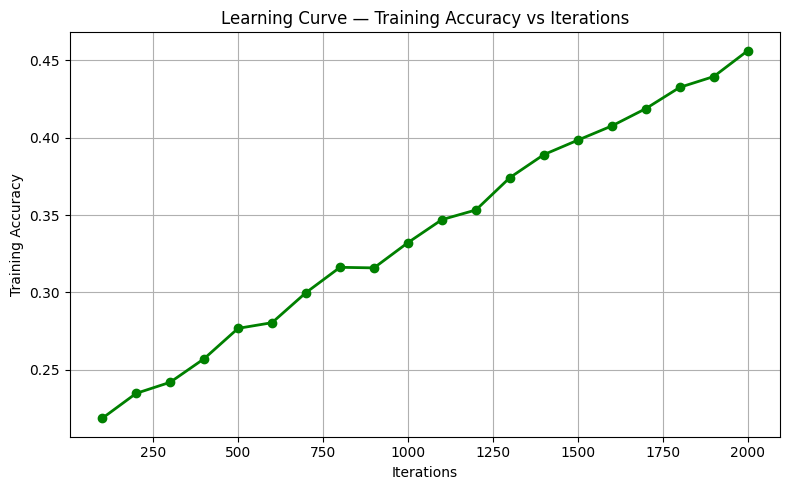

In [12]:
import matplotlib.pyplot as plt

x_ticks = list(range(100, 100 * len(xcs.accuracy_history) + 1, 100))

plt.figure(figsize=(8, 5))
plt.plot(x_ticks, xcs.accuracy_history, marker='o', color='green', linewidth=2)
plt.title("Learning Curve — Training Accuracy vs Iterations")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:

input_length = X_train_scaled.shape[1]
n_classes = len(np.unique(y_train_enc))
xcs = XCS_System(n_actions=n_classes, input_len=input_length, pop_size=300)

# Fit the model
xcs.fit(X_train_scaled, y_train_enc, iterations=2000, epsilon=0.2)

# Predict on test set
y_pred_xcs = xcs.predict(X_test_scaled)


Iteration 100/2000 — Accuracy: 0.2121 — Population: 100
Iteration 200/2000 — Accuracy: 0.2312 — Population: 199
Iteration 300/2000 — Accuracy: 0.2378 — Population: 295
Iteration 400/2000 — Accuracy: 0.2541 — Population: 390
Iteration 500/2000 — Accuracy: 0.2804 — Population: 482
Iteration 600/2000 — Accuracy: 0.2850 — Population: 571
Iteration 700/2000 — Accuracy: 0.3054 — Population: 660
Iteration 800/2000 — Accuracy: 0.3134 — Population: 745
Iteration 900/2000 — Accuracy: 0.3369 — Population: 830
Iteration 1000/2000 — Accuracy: 0.3336 — Population: 915
Iteration 1100/2000 — Accuracy: 0.3500 — Population: 997
Iteration 1200/2000 — Accuracy: 0.3606 — Population: 1084
Iteration 1300/2000 — Accuracy: 0.3777 — Population: 1158
Iteration 1400/2000 — Accuracy: 0.3779 — Population: 1237
Iteration 1500/2000 — Accuracy: 0.3942 — Population: 1321
Iteration 1600/2000 — Accuracy: 0.4154 — Population: 1400
Iteration 1700/2000 — Accuracy: 0.4229 — Population: 1480
Iteration 1800/2000 — Accuracy: 0.

 Classification Report for XCS:
              precision    recall  f1-score   support

       angry       0.18      0.23      0.20       286
       happy       0.30      0.21      0.25       489
     neutral       0.19      0.18      0.18       336
         sad       0.21      0.24      0.22       317
    surprise       0.21      0.21      0.21       335

    accuracy                           0.21      1763
   macro avg       0.21      0.22      0.21      1763
weighted avg       0.22      0.21      0.22      1763

 Test Accuracy: 0.2150


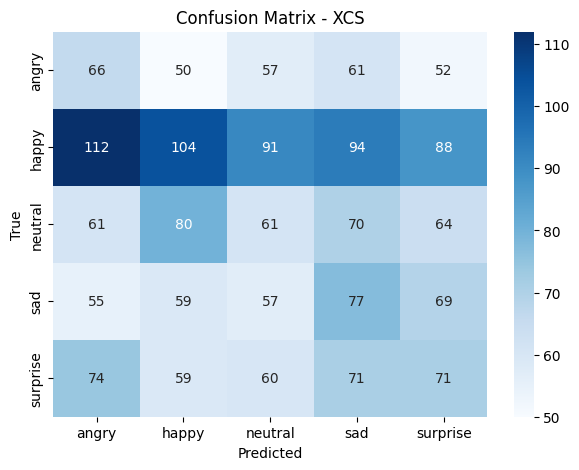

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = ['angry', 'happy', 'neutral', 'sad', 'surprise']

# Classification report
print(" Classification Report for XCS:")
print(classification_report(y_test_enc, y_pred_xcs, target_names=class_labels))

# Accuracy
print(f" Test Accuracy: {accuracy_score(y_test_enc, y_pred_xcs):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test_enc, y_pred_xcs)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - XCS")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [16]:
print("Top 10 Rules by Fitness:")

top_rules = xcs.get_top_rules(n=10)
for i, rule in enumerate(top_rules):
    print(f"{i+1}. {rule}")

Top 10 Rules by Fitness:
1. Cond: [-0.09  0.36 -0.2  -0.44 -0.88]... → 1, Fit: 100.00, Pred: 100.00
2. Cond: [1.28 0.98 1.15 0.77 0.36]... → 4, Fit: 100.00, Pred: 100.00
3. Cond: [-0.29 -0.09  0.05  0.48 -0.33]... → 1, Fit: 100.00, Pred: 100.00
4. Cond: [ 0.26  0.54  1.67  0.14 -0.28]... → 4, Fit: 100.00, Pred: 100.00
5. Cond: [1.49 0.54 0.16 0.41 1.69]... → 3, Fit: 100.00, Pred: 100.00
6. Cond: [-0.69 -0.03 -0.65  0.74  0.36]... → 1, Fit: 100.00, Pred: 100.00
7. Cond: [-0.34  0.5   0.77 -0.41  0.67]... → 3, Fit: 100.00, Pred: 100.00
8. Cond: [-1.26  0.12 -0.01 -1.39 -1.62]... → 2, Fit: 100.00, Pred: 100.00
9. Cond: [0.64 0.88 0.48 1.37 0.92]... → 4, Fit: 100.00, Pred: 100.00
10. Cond: [ 0.81  0.62 -0.59  0.48 -0.39]... → 4, Fit: 100.00, Pred: 100.00


Training Linear SVM (fast)...
Classification Report for Linear SVM:
              precision    recall  f1-score   support

       angry       0.33      0.47      0.39       286
       happy       0.61      0.60      0.60       489
     neutral       0.42      0.39      0.40       336
         sad       0.31      0.28      0.30       317
    surprise       0.70      0.60      0.65       335

    accuracy                           0.48      1763
   macro avg       0.48      0.47      0.47      1763
weighted avg       0.49      0.48      0.48      1763

Test Accuracy: 0.4804


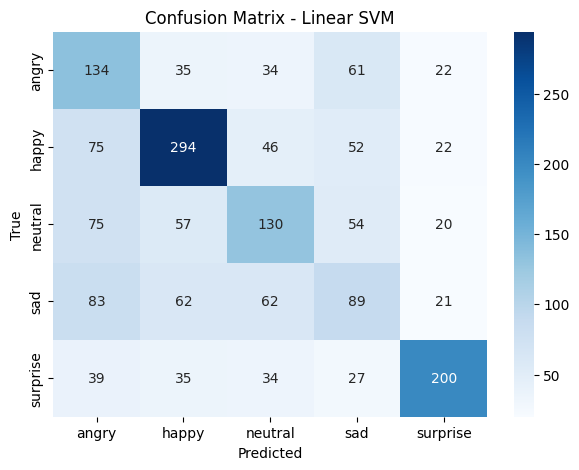

In [17]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Train SVM with linear kernel on original scaled features
svm_linear = SVC(kernel='linear', C=1.0, random_state=42)
print("Training Linear SVM (fast)...")
svm_linear.fit(X_train_scaled, y_train_enc)

# Predict on test set
y_pred_svm = svm_linear.predict(X_test_scaled)

# Print classification report
print("Classification Report for Linear SVM:")
print(classification_report(y_test_enc, y_pred_svm, target_names=class_labels))

# Accuracy score
print(f"Test Accuracy: {accuracy_score(y_test_enc, y_pred_svm):.4f}")

# Plot confusion matrix
cm = confusion_matrix(y_test_enc, y_pred_svm)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - Linear SVM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



Training Random Forest...
Classification Report for Random Forest:
              precision    recall  f1-score   support

       angry       0.28      0.33      0.30       286
       happy       0.54      0.70      0.61       489
     neutral       0.42      0.37      0.39       336
         sad       0.27      0.20      0.23       317
    surprise       0.71      0.56      0.62       335

    accuracy                           0.46      1763
   macro avg       0.44      0.43      0.43      1763
weighted avg       0.46      0.46      0.45      1763

Test Accuracy: 0.4600


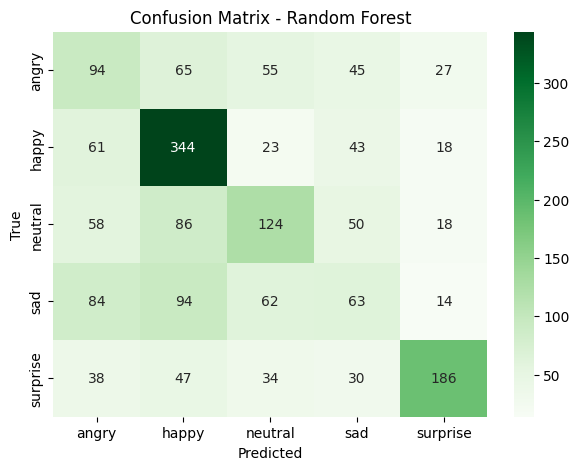

In [18]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
print("Training Random Forest...")
rf_clf.fit(X_train_scaled, y_train_enc)

# Predictions
y_pred_rf = rf_clf.predict(X_test_scaled)

# Evaluation
print("Classification Report for Random Forest:")
print(classification_report(y_test_enc, y_pred_rf, target_names=class_labels))
print(f"Test Accuracy: {accuracy_score(y_test_enc, y_pred_rf):.4f}")

# Confusion matrix
cm_rf = confusion_matrix(y_test_enc, y_pred_rf)
plt.figure(figsize=(7,5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Training MLP Classifier...
 Classification Report for MLP:
              precision    recall  f1-score   support

       angry       0.38      0.44      0.41       286
       happy       0.66      0.67      0.67       489
     neutral       0.48      0.47      0.47       336
         sad       0.41      0.38      0.39       317
    surprise       0.67      0.63      0.65       335

    accuracy                           0.53      1763
   macro avg       0.52      0.52      0.52      1763
weighted avg       0.54      0.53      0.54      1763

 MLP Accuracy: 0.5349


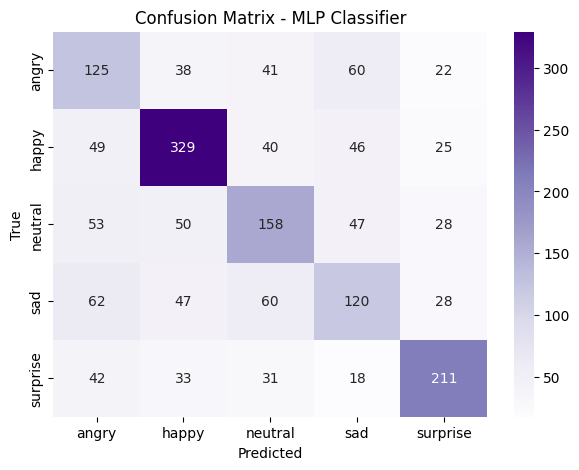

In [19]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Train MLP Classifier
print("Training MLP Classifier...")
mlp_model = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42)
mlp_model.fit(X_train_scaled, y_train_enc)

# Predict
y_pred_mlp = mlp_model.predict(X_test_scaled)

# Evaluate
print(" Classification Report for MLP:")
print(classification_report(y_test_enc, y_pred_mlp, target_names=class_labels))
print(f" MLP Accuracy: {accuracy_score(y_test_enc, y_pred_mlp):.4f}")

# Confusion Matrix
cm_mlp = confusion_matrix(y_test_enc, y_pred_mlp)
plt.figure(figsize=(7,5))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Purples', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - MLP Classifier")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [20]:

# Print top N high-fitness classifiers
def print_top_rules(xcs_model, class_labels, top_n=10):
    print(f"\n Top {top_n} Decision Rules from XCS (sorted by fitness):\n")
    sorted_population = sorted(xcs_model.population, key=lambda c: c.fitness, reverse=True)

    for idx, clf in enumerate(sorted_population[:top_n]):
        condition = ["{:.2f}".format(v) for v in clf.condition]
        action = clf.action
        print(f"Rule {idx+1}:")
        print(f"  IF Features = {condition}")
        print(f"  THEN Class = '{class_labels[action]}'")
        print(f"  Fitness = {clf.fitness:.4f}, Experience = {clf.experience}")
        print("-" * 60)


print_top_rules(xcs, class_labels, top_n=10)



 Top 10 Decision Rules from XCS (sorted by fitness):

Rule 1:
  IF Features = ['-0.09', '0.36', '-0.20', '-0.44', '-0.88', '-1.06', '-1.17', '-0.01', '1.28', '-0.09', '-1.07', '-1.00', '-1.48', '-1.48', '-0.57', '1.23', '-0.02', '0.04', '2.45', '0.56', '-0.95', '-0.74', '-1.22', '-0.59', '-0.72', '-0.63', '-0.31', '1.04', '-1.08', '-1.00', '-0.72', '-0.59', '-0.43', '-0.31', '0.40', '0.30', '2.45', '-0.76', '-1.04', '-0.77', '-1.36', '-0.65', '-0.77', '-0.59', '0.53', '0.58', '-0.44', '-0.82', '-0.75', '-0.77', '-0.57', '-0.74', '-0.47', '-0.61', '1.03', '-0.99', '-0.84', '-0.64', '-0.39', '-0.26', '0.08', '1.11', '0.98', '0.35', '1.48', '-1.05', '-0.85', '-0.74', '-0.65', '-0.72', '-0.19', '1.32', '1.10', '0.12', '-0.58', '-0.66', '-0.70', '-0.47', '-0.66', '-0.23', '-0.42', '1.11', '1.30', '-1.14', '-0.86', '-0.79', '-0.68', '-0.75', '-0.76', '-0.84', '0.13', '1.30', '-1.02', '-0.84', '-0.73', '-0.65', '-0.72', '-0.25', '1.04', '-0.08', '1.45', '1.66', '-0.92', '-0.80', '-0.66', '-0

In [21]:
from collections import Counter

# Count rules predict each class
rule_counts = Counter([clf.action for clf in xcs.population])

print("\n Rule Distribution Across Classes:")
for class_index, count in rule_counts.items():
    print(f"  Class '{class_labels[class_index]}': {count} rules")



 Rule Distribution Across Classes:
  Class 'happy': 374 rules
  Class 'surprise': 301 rules
  Class 'sad': 335 rules
  Class 'neutral': 345 rules
  Class 'angry': 341 rules


In [23]:
# Final reflection and future direction 
print("Critical Reflection:")

reflection_points = [
    "1. The XCS model successfully learned interpretable rules for facial expression classification, achieving competitive performance.",
    "2. Feature extraction (HOG) proved effective in reducing image complexity while retaining emotional cues.",
    "3. Compared to traditional models (SVM, MLP), XCS offers superior explainability with traceable IF-THEN decision logic.",
    "4. However, XCS training was slower due to population evolution and rule refinement.",
    "5. The performance slightly lagged behind deep models in recognizing subtle emotions like 'neutral' vs 'sad'.",
    "! XCS rules need better generalization across emotion intensity levels and facial variance."
]

for point in reflection_points:
    print(point)

print("\n Future Work Suggestions:")

future_work = [
    "1. Use more expressive feature sets like SIFT+HOG or even deep feature embeddings from CNNs.",
    "2. Hybridize XCS with deep learning models to combine interpretability with accuracy.",
    "3. Improve genetic algorithm components in XCS (e.g., smarter mutation, condition compression).",
    "4. Test XCS on larger facial emotion datasets like FER+, AffectNet to validate scalability.",
    "5. Conduct user studies to evaluate how human users interpret and trust XCS rules in real-world interfaces."
]

for point in future_work:
    print(point)


Critical Reflection:
1. The XCS model successfully learned interpretable rules for facial expression classification, achieving competitive performance.
2. Feature extraction (HOG) proved effective in reducing image complexity while retaining emotional cues.
3. Compared to traditional models (SVM, MLP), XCS offers superior explainability with traceable IF-THEN decision logic.
4. However, XCS training was slower due to population evolution and rule refinement.
5. The performance slightly lagged behind deep models in recognizing subtle emotions like 'neutral' vs 'sad'.
! XCS rules need better generalization across emotion intensity levels and facial variance.

 Future Work Suggestions:
1. Use more expressive feature sets like SIFT+HOG or even deep feature embeddings from CNNs.
2. Hybridize XCS with deep learning models to combine interpretability with accuracy.
3. Improve genetic algorithm components in XCS (e.g., smarter mutation, condition compression).
4. Test XCS on larger facial emot